
<h1><center> <font color='black'>  Network Science (LTAT.02.011) - Homework - 03  (Total points - 15)</font></center></h1>
<h2><center> <font color='black'> Introduction to Network Analysis</font></center></h3>
<h2><center> <font color='black'> University of Tartu</font></center></h3>


================================================================================================================

# Homework instructions


- Please provide the names and student IDs of the team-members (Maximum 2 person) in the field "Team mates" below. If you are not working in a team please insert only your name and student ID. 

- ONLY one of the teammates should submit the homework. We will grade the homework and the marks and feedback is applied for both the team members. So please communicate with your team member about marks and feedback if you are submit the homework.


- The accepted submission format is .ipynb file. Please upload the file on moodle.

- The submission will automatically close on **<font color='red'>21st April 2021 at 23:59 pm</font>**, so please make sure you have enough time to submit the homework. 

- You do not necessarily need to work on Colab. Especially as the size and the complexity of datasets will increase through the course, you can install jupyter notebooks locally and work from there.

- If you do not understand what a question is asking for, please ask in Moodle. 

- Please Click on "**Restart and Run All**" before uploading the '.ipynb' file.

- Plagiarism is <font color='red'>**PROHIBITED**</font>. Any form of plagiarism will be dealt according to the university policy (https://www.ut.ee/en/current-students/academic-fraud).

- **Note: The tasks which involves writing your thoughts should not contain more than 3-4 sentences. It should be clear and concise.**


**<h2><font color='red'>Student info:</font></h2>**


<font color='red'>Full name: </font> Hannula-Katrin Pandis, Canberk Özen

<font color='red'>Student ID: </font> B04920, B97964



================================================================================================================

# 1. Node Classification using Graph Convolutional Network (10 points)
documentation for reference - https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html 

# Libraries

In [ ]:
!pip install stellargraph

     |████████████████████████████████| 440kB 7.1MB/s 


In [ ]:
# Importing required libraries (install other libraries if needed)
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import globalvar
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras.callbacks import EarlyStopping
from stellargraph import StellarGraph
from stellargraph.datasets import Cora

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

## 1.1 Processing on the dataset (1 point)

Reference: https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

**1.1.1 Download the Cora dataset into your local machine and do some pre-processing.  (0.5 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

We’ve been using a synthetic graph with perfectly formatted data as an example till now, because it helps us focus on just the core StellarGraph functionality. Real life isn’t so simple; there’s usually files to wrangle and formats to convert, so we’ll use real data in this notebook to go from data in files to a StellarGraph.

We’ll work with the Cora dataset from https://linqs.soe.ucsc.edu/data:

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

The dataset contains two files: cora.cites and cora.content.

cora.cites is a tab-separated values (TSV) file of the graph edges. The first column identifies the cited paper, and the second column identifies the paper that cites it. The first three lines of the file look like:

35  1033<br>
35  103482<br>
35  103515<br>
...
cora.content is also a TSV file of information about each node (paper), with 1435 columns: the first column is the node ID (matching the IDs used in cora.cites), the next 1433 are the 0/1-values of word vectors, and the last is the subject area class of the paper. The first three lines of the file look like (with the 1423 of the 0/1 columns truncated)

31336   0   0   ... 0   1   0   0   0   0   0   0   Neural_Networks<br>
1061127 0   0   ... 1   0   0   0   0   0   0   0   Rule_Learning<br>
1106406 0   0   ... 0   0   0   0   0   0   0   0   Reinforcement_Learning<br>
...
This graph is homogeneous (all nodes are papers, and all edges are citations), with node features (the 0/1-values) but no edge weights.

The StellarGraph library provides the datasets module for working with some common datasets via classes like Cora (docs). It can download the necessary files via the download method. (The load method also converts it into a StellarGraph, but that’s too helpful for this tutorial: we’re learning how to do that ourselves.)

In [ ]:
# Cora dataset download
cora = Cora()
cora.download()

# the base_directory property tells us where it was downloaded to:
cora_cites_file = os.path.join(cora.base_directory, "cora.cites")
cora_content_file = os.path.join(cora.base_directory, "cora.content")

We’ve now got the files on disk, so we can read them using the pd.read_csv function. Despite the “CSV” in the name, this function can be used to read TSV files too. The files don’t have a row of column headings, so we’ll want to set our own.

First, the edges. We can use source and target as the column headings, to match StellarGraph’s defaults. However, the natural phrasing is “paper X cites paper Y”, not “paper Y is cited by paper X”, so we use the columns in reverse order to match.

In [ ]:
cora_cites = pd.read_csv(
    cora_cites_file,
    sep="\t",  # tab-separated
    header=None,  # no heading row
    names=["target", "source"],  # set our own names for the columns
)
cora_cites

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


Now, the nodes. Again, we have to choose the columns’ names. The names of the 0/1-columns don’t matter so much, but we can give the first column (of IDs) and the last one (of subjects) useful names.

In [ ]:
cora_feature_names = [f"w{i}" for i in range(1433)]

cora_raw_content = pd.read_csv(
    cora_content_file,
    sep="\t",  # tab-separated
    header=None,  # no heading row
    names=["id", *cora_feature_names, "subject"],  # set our own names for the columns
)
cora_raw_content

,id,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,w19,w20,w21,w22,w23,w24,w25,w26,w27,w28,w29,w30,w31,w32,w33,w34,w35,w36,w37,w38,...,w1394,w1395,w1396,w1397,w1398,w1399,w1400,w1401,w1402,w1403,w1404,w1405,w1406,w1407,w1408,w1409,w1410,w1411,w1412,w1413,w1414,w1415,w1416,w1417,w1418,w1419,w1420,w1421,w1422,w1423,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432,subject
0,31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Case_Based


As we saw above when adding node features, StellarGraph uses the index of the DataFrame as the connection between a node and a row of the DataFrame. Currently our dataframe just has a simple numeric range as the index, but it needs to be using the id column. Pandas offers a few ways to control the indexing; in this case, we want to replace the current index by moving the id column to it, which is done most easily with set_index:

In [ ]:
cora_content_str_subject = cora_raw_content.set_index("id")
cora_content_str_subject

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,w19,w20,w21,w22,w23,w24,w25,w26,w27,w28,w29,w30,w31,w32,w33,w34,w35,w36,w37,w38,w39,...,w1394,w1395,w1396,w1397,w1398,w1399,w1400,w1401,w1402,w1403,w1404,w1405,w1406,w1407,w1408,w1409,w1410,w1411,w1412,w1413,w1414,w1415,w1416,w1417,w1418,w1419,w1420,w1421,w1422,w1423,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432,subject
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


We’re almost ready to create the StellarGraph, we just have to do something about the non-numeric subject column. Many machine learning models only work on numeric features, requiring text and other data to be converted before apply; the models in StellarGraph are no different.

There are two options, depending on the task:

1. remove the subject column entirely: many uses of Cora are predicting the subject of a node, given all of the graph structure and other information, so including it as information in the graph is giving the answer directly

2. convert it to numeric via one-hot encoding, where we have 7 columns of 0 and 1, one for each subject value (similar to the 1433 other w... features). <br>
**We will be using option - 1 in this notebook,**

**Removing columns**<br>
Let’s start with the first, removing the columns. The drop method lets us remove one or more columns.

In [ ]:
cora_content_no_subject = cora_content_str_subject.drop(columns="subject")
cora_content_no_subject

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,w19,w20,w21,w22,w23,w24,w25,w26,w27,w28,w29,w30,w31,w32,w33,w34,w35,w36,w37,w38,w39,...,w1393,w1394,w1395,w1396,w1397,w1398,w1399,w1400,w1401,w1402,w1403,w1404,w1405,w1406,w1407,w1408,w1409,w1410,w1411,w1412,w1413,w1414,w1415,w1416,w1417,w1418,w1419,w1420,w1421,w1422,w1423,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We’ve got all the right node data, and the right edges, so now we can create a StellarGraph using the techniques we saw in the “homogeneous graph with features” section above.

In [ ]:
cora_no_subject = StellarGraph({"paper": cora_content_no_subject}, {"cites": cora_cites})
#TODO Print this output
print(cora_no_subject.info())


StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


If we’re trying to predict the subject, we’ll probably need to use the subject labels as ground-truth labels in a supervised or semi-supervised machine learning task. This can be extracted from the DataFrame and held separately, to be passed in as training, validation or test examples.

In [ ]:
cora_subject = cora_content_str_subject["subject"]
cora_subject

id
31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object

In [ ]:
cora_subject.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


**1.1.2 Splitting the data.  (0.5 point)**<br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>


For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. Use scikit-learn’s train_test_split function to do this.

Here we’re taking 200 node labels for training, 600 for validation, and the rest for testing.

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    cora_subject, train_size=200, test_size=None, stratify=cora_subject
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=600, test_size=None, stratify=test_subjects
)

Note using stratified sampling gives the following counts:

In [ ]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,60
Probabilistic_Methods,32
Genetic_Algorithms,31
Theory,26
Case_Based,22
Reinforcement_Learning,16
Rule_Learning,13


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays
For our categorical target, we will use one-hot vectors that will be compared against the model’s soft-max output. To do this conversion we can use the LabelBinarizer transform from scikit-learn. Another option would be the pandas.get_dummies function, but the scikit-learn transform allows us to do the inverse transform easily later in the notebook, to interpret the predictions.

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

## 1.2  GCN  (9 points)

Create a generator instance by using grah object.

In [ ]:
generator = FullBatchNodeGenerator(cora_no_subject, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

**1.2.1 Define two GCN models here. In first, use 32 as hidden units in both the layers, keep activation function as relu, dropout layer as 40%. In second, use 32 as hidden units in both the layers, keep activation function as relu, dropout layer as 60%. (1 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>


In [ ]:
gcn1 = GCN(
    #TODO
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.4
)

In [ ]:
gcn2 = GCN(
    #TODO
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.6
)

**1.2.2 What you think what should happen by changing the parameters of GCN model here? Should performance of the test set increases or decreases? State your reasons. (1 point)** <br>
<font color='red'>Write your observation in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** Increasing the dropout rate may result in our model generalizing to unseen data, thus using the second model may increase the test set accuracy. It may also backfire though, since a dropout rate of 0.6 may result in our second GCN not being able to learn from the training data well enough compared to the first model.

To create a Keras model we now expose the input and output tensors of the GCN model for node prediction, via the GCN.in_out_tensors method: <br>
**Note: Use the first GCN model we created by the name of 'gcn1' instance for all the steps below.**

In [ ]:
x_inp, x_out = gcn1.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'gather_indices')>

**1.2.3 Define the last layer, that is, softmax layer (1 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>


In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out) #TODO

**1.2.4 Compile the model. Keep the parameters same as was discussed in the lab (1 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    #TODO
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

**1.2.5 Train the model. Keep the parameters same as was discussed in the lab (1 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
history = model.fit(
    #TODO
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9395 - acc: 0.1900 - val_loss: 1.8558 - val_acc: 0.3150
Epoch 2/200
1/1 - 0s - loss: 1.8370 - acc: 0.3250 - val_loss: 1.7529 - val_acc: 0.3117
Epoch 3/200
1/1 - 0s - loss: 1.7252 - acc: 0.3300 - val_loss: 1.6507 - val_acc: 0.3133
Epoch 4/200
1/1 - 0s - loss: 1.5914 - acc: 0.3350 - val_loss: 1.5508 - val_acc: 0.3500
Epoch 5/200
1/1 - 0s - loss: 1.4358 - acc: 0.4000 - val_loss: 1.4310 - val_acc: 0.4800
Epoch 6/200
1/1 - 0s - loss: 1.2649 - acc: 0.5550 - val_loss: 1.3066 - val_acc: 0.5850
Epoch 7/200
1/1 - 0s - loss: 1.1228 - acc: 0.6550 - val_loss: 1.1858 - val_acc: 0.6633
Epoch 8/200
1/1 - 0s - loss: 0.9753 - acc: 0.7550 - val_loss: 1.0693 - val_acc: 0.7150
Epoch 9/200
1/1 - 0s - loss: 0.8279 - acc: 0.8200 - val_loss: 0.9642 - val_acc: 0.7583
Epoch 10/200
1/1 - 0s - loss: 0.6828 - acc: 0.8550 - val_loss: 0.8841 - val_acc: 0.7633
Epoch 11/200
1/1 - 0s - loss: 0.5773 - acc: 0.8650 - val_loss: 0.8308 - val_acc: 0.7617
Epoch 12/200
1/1 - 0s - loss: 0.4592 - ac

**1.2.6 Plot the accuracy and loss of the train and validation set (1 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

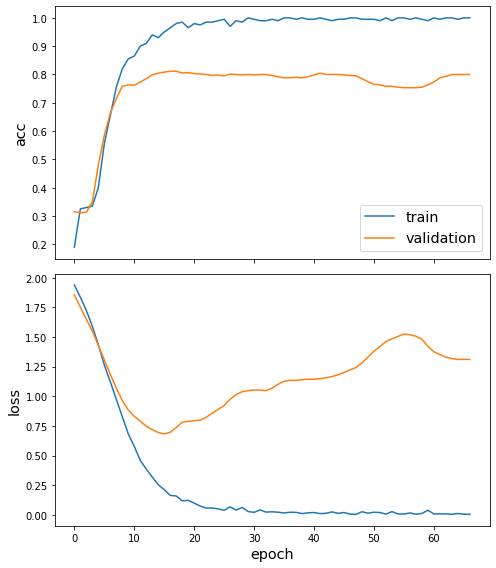

In [ ]:
#TODO
sg.utils.plot_history(history)

**1.2.7 What do you observe in terms of performance of the model here? Explain in your own words. (1 point)** <br>
<font color='red'>Write your observation in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** (answered before Restarting Kernel and Run All) Between epochs 10 and 15, the validation accuracy starts to stabilize into a constant value while the training accuracy keeps increasing. Also between these epochs, the validation loss starts to stabilize, and if we train more than 20 epochs it starts to increase while the training loss keeps decreasing after epoch 20.

What this means is that the model overfits to training data after around 15 to 20 epochs.

**1.2.8 Use the test set to predict the trained model. (1 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets) #TODO

In [ ]:
test_metrics = model.evaluate(test_gen) #TODO
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 57ms/step - loss: 0.6813 - acc: 0.8050

Test Set Metrics:
	loss: 0.6813
	acc: 0.8050


**1.2.9 How can we improve the accuracy here? Write your suggestions. (1 point)** <br>
<font color='red'>Write your observation in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** We have used EarlyStopping, but it was clear from the plots that a patience of 50 epochs was too big to prevent overfitting. One suggestion would be to decrease the patience value to a small number, something between 5 and 10, so that we won't miss the turning point after which validation acc stabilizes while the training acc keeps increasing.

Another option would be to play with model parameters. We have only tried two different dropout values, maybe we should try out more to find the best dropout rate which reduces model variance yet not incurring any significant bias penalty.

The same thing goes for layer sizes and the number of layers as well. One can use quite sophisticated methods like bayesian optimization to find nearly ideal parameters for our model.

Lastly, increasing the size of the training data will always help in reducing the variance. Especially in this situation, where our validation and test datasets are bigger compared to it. 

# 2. Node classification with GraphSAGE (5 points)
Reference: https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html

## Libraries

In [ ]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

**2.1 Use the same dataset as used in the 1.1. Define number of samples as 10, 5 for each of the layers (there are 2 layers) and set size of the batch as 50.(0.5 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
batch_size = 50 #TODO
num_samples = [10, 5] #TODO

**2.2 Use required parameters here for GraphSAGENodeGenerator.(0.5 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
generator = GraphSAGENodeGenerator(cora_no_subject, batch_size, num_samples) #TODO

In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

**2.3 Here, try atleast three different values of hidden neurons here for both the layers. keep the number of neurons same for both the layers for each model. (1 point)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
graphsage_model1 = GraphSAGE(
    layer_sizes= [32, 32],  #TODO, 
    generator=generator, bias=True, dropout=0.5,
)

In [ ]:
graphsage_model2 = GraphSAGE(
    layer_sizes= [64, 64], #TODO, 
    generator=generator, bias=True, dropout=0.5,
)

In [ ]:
graphsage_model3 = GraphSAGE(
    layer_sizes= [128, 128], #TODO, 
    generator=generator, bias=True, dropout=0.5,
)

**2.4 Now, use all these three models one by one and compute the test accuracy and loss. Add as many extra cells required. (2 points)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
# For model 1
x_inp1, x_out1 = graphsage_model1.in_out_tensors() #TODO
prediction1 = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out1) #TODO

In [ ]:
# For model 2
x_inp2, x_out2 = graphsage_model2.in_out_tensors() #TODO
prediction2 = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out2) #TODO

In [ ]:
# For model 3
x_inp3, x_out3 = graphsage_model3.in_out_tensors() #TODO
prediction3 = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out3) #TODO

In [ ]:
# For model 1
model1 = Model(inputs=x_inp1, outputs=prediction1)
model1.compile(
    #TODO
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"]
)

In [ ]:
# For model 2
model2 = Model(inputs=x_inp2, outputs=prediction2)
model2.compile(
    #TODO
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"]
)

In [ ]:
# For model 3
model3 = Model(inputs=x_inp3, outputs=prediction3)
model3.compile(
    #TODO
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"]
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
# For model 1, 2, 3
test_gen = generator.flow(test_subjects.index, test_targets) #TODO)

In [ ]:
# For model 2

In [ ]:
# For model 3

In [ ]:
# For model 1
history1 = model1.fit(
    #TODO
    train_gen, epochs=15, validation_data=val_gen, verbose=0, shuffle=False
)

In [ ]:
# For model 2
history2 = model2.fit(
    #TODO
    train_gen, epochs=15, validation_data=val_gen, verbose=0, shuffle=False
)

In [ ]:
# For model 3
history3 = model3.fit(
    #TODO
    train_gen, epochs=15, validation_data=val_gen, verbose=0, shuffle=False
)

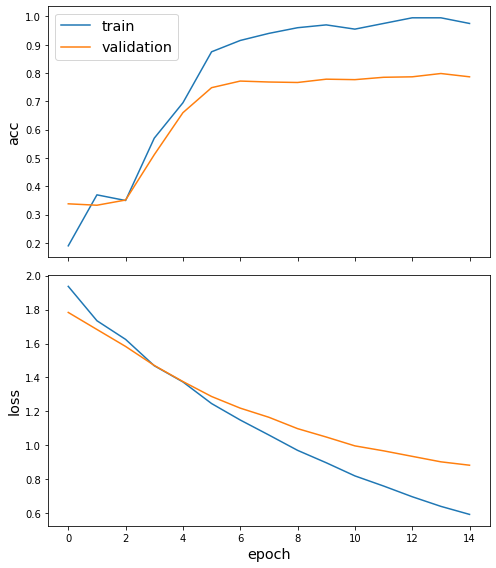

In [ ]:
# For model 1
sg.utils.plot_history(history1) #TODO)

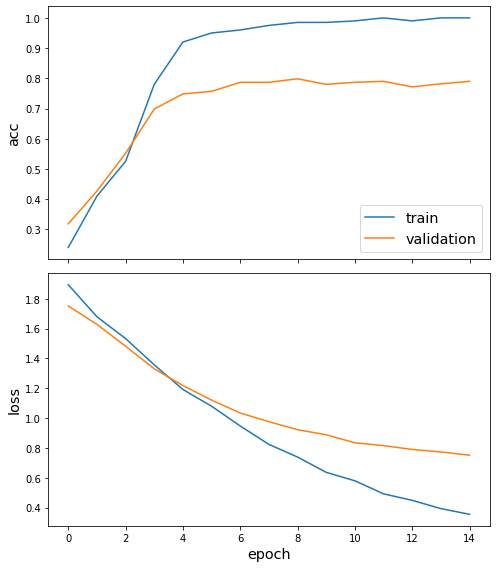

In [ ]:
# For model 2
sg.utils.plot_history(history2)

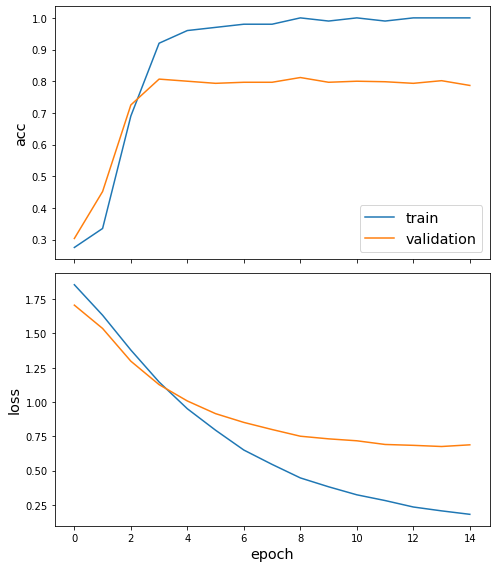

In [ ]:
# For model 3
sg.utils.plot_history(history3)

In [ ]:
# For model 1
test_metrics1 = model1.evaluate(test_gen) #TODO)
print("\nTest Set 1 Metrics:")
for name, val in zip(model1.metrics_names, test_metrics1):
    print("\t{}: {:0.4f}".format(name, val))

39/39 [==============================] - 2s 45ms/step - loss: 0.8901 - acc: 0.7757

Test Set 1 Metrics:
	loss: 0.8901
	acc: 0.7757


In [ ]:
# For model 2
test_metrics2 = model2.evaluate(test_gen) #TODO)
print("\nTest Set 2 Metrics:")
for name, val in zip(model2.metrics_names, test_metrics2):
    print("\t{}: {:0.4f}".format(name, val))

39/39 [==============================] - 2s 44ms/step - loss: 0.7696 - acc: 0.7867

Test Set 2 Metrics:
	loss: 0.7696
	acc: 0.7867


In [ ]:
# For model 3
test_metrics3 = model3.evaluate(test_gen) #TODO)
print("\nTest Set 3 Metrics:")
for name, val in zip(model3.metrics_names, test_metrics3):
    print("\t{}: {:0.4f}".format(name, val))

39/39 [==============================] - 2s 47ms/step - loss: 0.7061 - acc: 0.7898

Test Set 3 Metrics:
	loss: 0.7061
	acc: 0.7898


**2.5 What are your observations on three different models you built and evaluated those three models on the test set. How the performance is affected? (1 point)** <br>
<font color='red'>Write your observation in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** After checking the graphs, we see that increasing the number of neurons makes the models more prone to overfitting the training data in a smaller number of epochs, yet at the same time our test metrics say that using more neurons increases the accuracy a little. 

Probably the best approach is to use model3 with an optimized early stopping criteria&dropout rate. If not so much improvements happen, then focusing on optimizing model2 would be a better choice.

## How long did it take you to solve the homework?

* Please answer as precisely as you can. It does not affect your points or grade in any way. It is okay, if it took 0.5 hours or 24 hours. The collected information will be used to improve future homeworks. Please change X into your estimate.

<font color='red'> **Answer:**</font> 10 hours 

## What is the level of difficulty for this homework?
Please put a number between $0:10$ ($0:$ easy, $10:$ difficult)

<font color='red'> **Answer:**</font>